## Get and prepare the image

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.ndimage import gaussian_filter

(200, 200, 3)


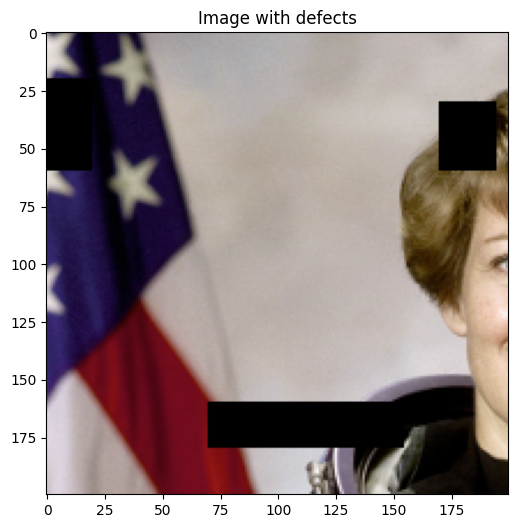

In [2]:
mask_rgb=[0,0,0]
image_orig = data.astronaut()[0:200,0:200].astype(np.float32) / 255.0
pad_size = 60
# Create mask with three defect regions: left, middle, right respectively
mask = np.zeros(image_orig.shape[:-1])

mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1

# Defect image over the same region in each color channel
image_defect = image_orig.copy()
for layer in range(image_defect.shape[-1]):
 image_defect[np.where(mask)] = mask_rgb

subplot, arr = plt.subplots(1, 1)
arr.imshow(image_defect, cmap='gray')
arr.set_title("Image with defects")
plt.gcf().set_size_inches((6,6))

print(image_defect.shape)

## Funciones auxiliares

In [2]:
# Import binary erosion
from scipy.ndimage import binary_erosion

template = np.zeros(shape=(3,3), dtype=np.float16)
template[0,0] = 1
template[-1, -1] = 1
template[-1, 0] = 1
template[0, -1] = 1

def erosion(image, mask = template):
    """
        Returns
        -------
        np.array 
          Image with values 1 where the ring is (pixels to replace, external pixels)
    """
    ring = image - binary_erosion(image, template) 
    return ring.astype(np.float16) 

# Function to calculate SSD (Sum of Square Distances)
def ssd(patch1, patch2, mask):
    """
        Applies ssd to two patches where the mask is 1
    
        Returns
        -------
         int
           sum of square distances
    """
    return np.sum((patch1 - patch2) ** 2, where=mask)

def get_window_and_search_area(image, coords: tuple[int, int], window_size=11, search_area_size=21):
    """
        returns: window. Image with values 1 where the window is (pixels to replace, external pixels)
    """
    x, y = coords
    window_coords = max(0, x - window_size//2), min(image.shape[0], x + window_size//2 + 1), \
                         max(0, y - window_size//2), min(image.shape[1], y + window_size//2 + 1)
    
    window = image[window_coords[0]:window_coords[1], window_coords[2]:window_coords[3]]

    search_area = image[max(0, x - search_area_size//2): min(image.shape[0], x + search_area_size//2 + 1), 
                        max(0, y - search_area_size//2): min(image.shape[1], y + search_area_size//2 + 1)]
    return window, window_coords, search_area


def get_inv_gaussian_ponderation(window_size):

    '''
        This method 

        Retunrs
        -------
        np.array
          Inverted gaussian ponderation matrix
    '''

    aux = np.zeros((window_size, window_size))

    aux[aux.shape[0] // 2, aux.shape[1] // 2] = 1

    gaussian_image = gaussian_filter(aux, sigma=3, axes=(0, 1))

    inverted_gaussian_image = 1 - gaussian_image

    inverted_gaussian_image /= np.sum(inverted_gaussian_image)
    
    return inverted_gaussian_image

def get_padded_image(image, mask):

    pad_size = 24
    image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')

    mask = np.pad(mask, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
    
    return image, mask

# Metodo 

In [4]:
from random import choice

# Función para encontrar el parche que mejor coincida
def fix_image(image, mask, window_size=11, search_size=21, topn : int = 0, padding : bool = True, suavicacion : bool = True):
    
    original_dimensions = image.shape

    # Conseguimos la imagen con padding
    if padding:
        image, mask =  get_padded_image(image, mask)
    
    image = image.copy()
    mask = mask.copy()

    mask_ = mask.copy()
    
    # Imagen invertida de gauss, para ponderar ssd
    gauss_pondered_image = get_inv_gaussian_ponderation(search_size)

    # Mientras haya píxeles de la máscara por explorar
    while mask.any():
        # Obtener el anillo de la máscara y los índices de los píxeles a explorar
        ring = erosion(mask)
        ring_indices = np.argwhere(ring)

        # Por cada pixel del anillo a explorar
        for pX, pY in ring_indices:
            # Crear un área de búsqueda y una ventana
            window, window_coords, search_area = get_window_and_search_area(image, (pX, pY), window_size, search_size)
            
            best_ssd = np.inf
            best_pixel = np.array([0, 0])

            # Creamos la mascara que corresponde a la ventana
            mask_template = mask[window_coords[0]:window_coords[1], window_coords[2]:window_coords[3]] == 0
            mask_template = np.stack([mask_template]*3, axis=-1) # Hacemos la mascara un tensor de 3 canales para poder hacer el where en ssd
            
            dx, dy = window_coords[1] - window_coords[0], window_coords[3] - window_coords[2]
            
            ssd_list = [] # Lista para almacenar los valores ssd topn

            # Para cada posición en el área de búsqueda, calcular el SSD y obtener el valor mínimo
            for i in range(search_area.shape[0] - window_size):
                for j in range(search_area.shape[1] - window_size):
                    
                    search_zone = search_area[i:i+dx, j:j+dy]

                    # Calculamos el ssd de esta ventana con este search_zone
                    ssd_value = ssd(window, search_zone, mask_template) * gauss_pondered_image[i:i+dx, j:j+dy][i, j]

                    if topn: # Si topn es distinto de 0, almacenamos los valores ssd
                        if ssd_value != 0 and mask_template[i, j, 0] == 1:
                            ssd_list.append((ssd_value, search_zone[search_zone.shape[0] // 2, search_zone.shape[1] // 2]))

                    else:
                        if ssd_value < best_ssd and ssd_value != 0 and mask_template[i, j, 0] == 1: # and search_zone[search_zone.shape[0] // 2, search_zone.shape[1] // 2].any():
                            best_ssd = ssd_value
                            best_pixel = search_zone[search_zone.shape[0] // 2, search_zone.shape[1] // 2]
                    

            # Si topn es distinto de 0, seleccionamos un pixel aleatorio de los topn
            if topn:
                lista = sorted(ssd_list, key=lambda x: x[0])[:topn]

                if not len(lista): continue
                
                best_pixel = choice(lista)[1]


            # Reemplazar el píxel con el parche que mejor coincida
            if best_pixel.any():
                image[pX, pY] = best_pixel

        # Actualizar la máscara
        mask -= ring

    # Aplicamos un filtro gaussiano para suavizar los bordes
    if suavicacion:
        image_ = gaussian_filter(image, sigma=0.8, axes=(0, 1))
        mask_ = gaussian_filter(mask_, sigma=1.0, axes=(0, 1))

        image[mask_ > 0.05] = image_[mask_ > 0.05]

    x, y, _= image.shape

    padX, padY = (x - original_dimensions[0]) // 2, (y - original_dimensions[1]) // 2

    return image[padX:x-padX, padY:y-padY]

# Explicación
## Padding

Reemplazo el anillo del onion ring una vez completado todo el anillo. Es decir, al calcular el mejor color para el píxel anillo[0], el píxel anillo[1] no tendrá en cuenta el píxel anillo[0] ya que la máscara no se ha modificado, solo se considerará a partir del píxel anillo2[0].

Esto genera un problema con los parches en los bordes de la imagen (como en el lado izquierdo, en la bandera), porque si el área de búsqueda es muy pequeña, los píxeles en una latitud central tendrán toda el área de búsqueda perteneciente a la máscara, calculando un SSD de 0 siempre.

Para solucionarlo, hacemos padding, de forma que ahora los píxeles tendrán más espacio sin máscara en el área de búsqueda para encontrar un píxel coincidente.


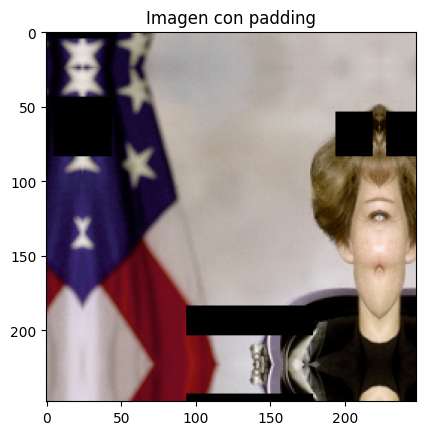

In [5]:
plt.title("Imagen con padding")
plt.imshow(get_padded_image(image_defect, mask)[0], cmap='gray')

Aqui podemos ver la diferencia del algoritmo usando padding o no usandolo.

Como vemos, hay regiones en las que no encuentra el mejor pixel, ya que simplemente no hay zonas donde buscar.

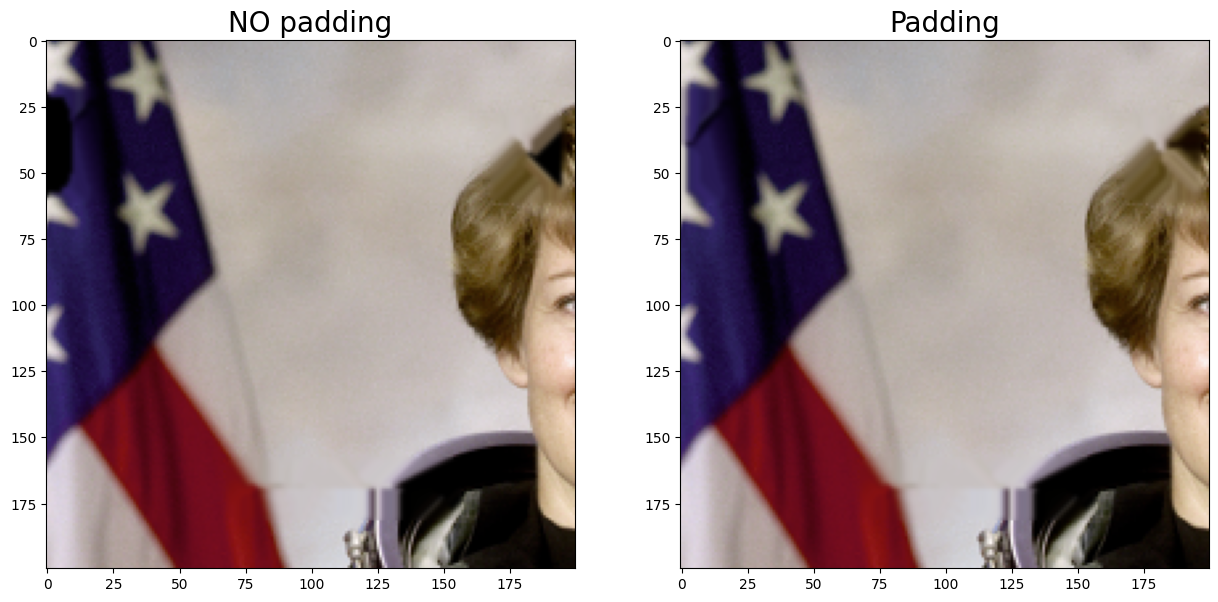

In [6]:
fontdict = {'fontsize': 20}
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
plt.title("NO padding", fontdict=fontdict)
plt.imshow(fix_image(image_defect, mask, topn=0, padding = False), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title("Padding", fontdict=fontdict)
plt.imshow(fix_image(image_defect, mask, topn=0, padding = True), cmap='gray')

# Gaussiana invertida

Uso una gaussiana invertida para ponderar el ssd value, de forma que cuanto más lejos está del pixel que estamos reemplazando más valor tendrá. Tiene una sigma de 3, la intención es no hacer el valle (parte oscura) ni muy grande ni muy pequeña, ya que no quiero ni descartar completamente por proximidad, ni valorar muchisimo los pixeles muy lejanos.
A continuación la gaussiana que estoy utilizando

0.002232534346605534


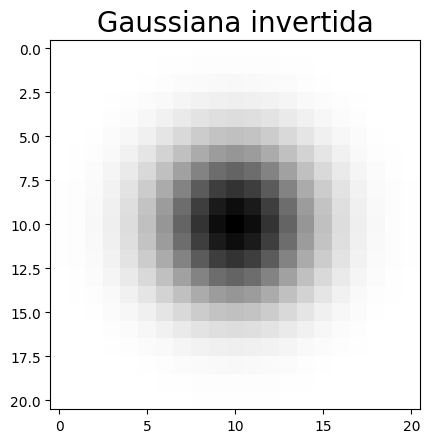

In [ ]:
plt.title("Gaussiana invertida", fontdict={'fontsize': 20})
plt.imshow(get_inv_gaussian_ponderation(21), cmap='gray')

# Onion ring

Utilizo la técnica onion ring de forma que voy reemplazando los pixeles en forma de anillo, y no linea por linea.

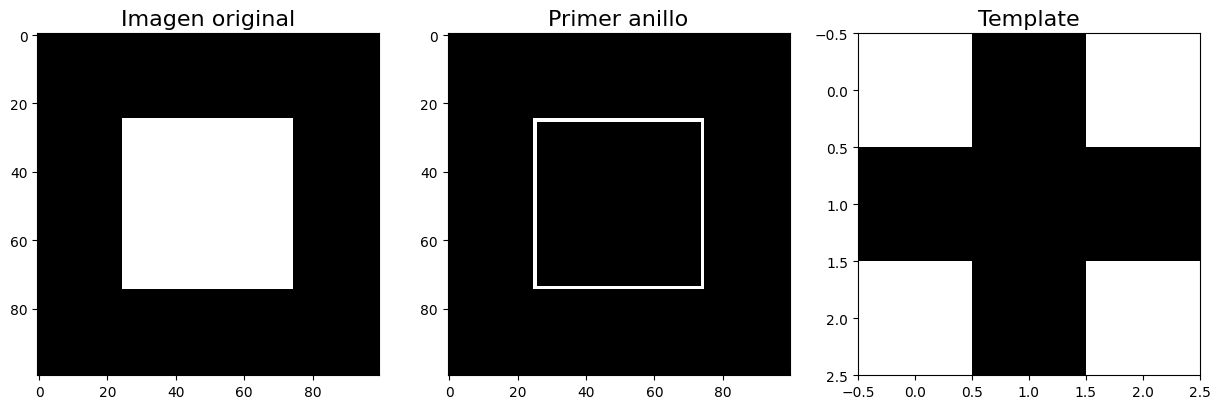

In [8]:
# Crear una imagen en negro
image_size = (100, 100)
black_image = np.zeros(image_size)

# Definir el tamaño del cuadrado blanco
square_size = 50
start = (image_size[0] - square_size) // 2
end = start + square_size

# Dibujar el cuadrado blanco en el medio
black_image[start:end, start:end] = 1

# Mostrar la imagen
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,3,1)
plt.title("Imagen original", fontdict={'fontsize': 16})
plt.imshow(black_image, cmap='gray')

fig.add_subplot(1,3,2)
plt.title("Primer anillo", fontdict={'fontsize': 16})
plt.imshow(erosion(black_image, template), cmap='gray')

fig.add_subplot(1,3,3)
plt.title("Template", fontdict={'fontsize': 16})
plt.imshow(template, cmap='gray')

plt.show()

# Top N
Utilizo la técnica top N, un parámetro de la función que permite coger aleatóriamente entre los n pixeles con menor ssd_value.

Este cambio tiene varias cosas que podemos observar:

- Determinismo:
    Aunque es trivial, creo que es importante destacar que usar un metodo top N escogiendo aleatoriamente los mejores pixeles añade algo de indeterminismo al algoritmo, de forma que ahora pueden salir resultados diferentes para el mismo input.

- Percepción:
    Según lo que yo he observado, parece tener resultados muy buenos, por ejemplo, en el pelo de la astronauta, em cambio, no parece tener tan buenos resultados en la bandera. Esto se podria deber a que el pelo es una zona sin patrones exactos, valores de pixeles similares y con mucha variación, en cambio en la bandera es todo lo contrario, hay patrones (las estrellas) y los pixeles tienden a tener un color ciertamente más preciso, por lo tanto parece tener un peor resultado.

- Con un valor de top N muy alto los pixeles son demasiado aleatórios, sobretodo aplicando la gaussiana invertida para ponderar.

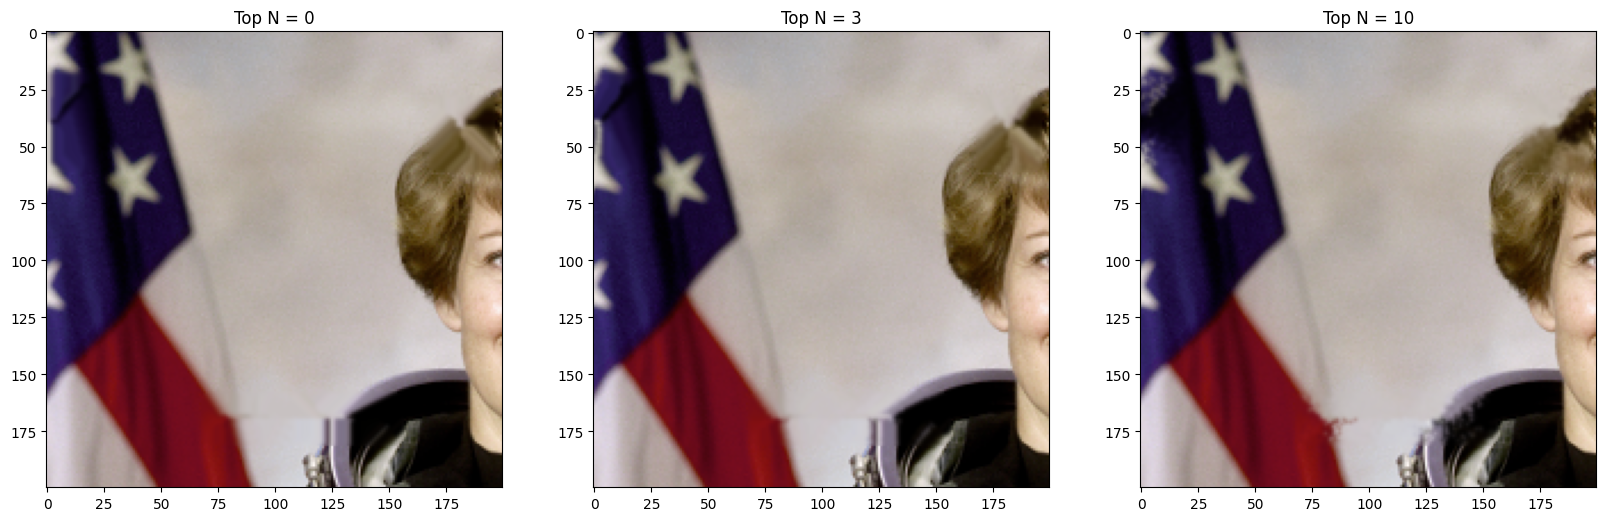

In [9]:
fig = plt.figure(figsize=(20, 20))

fig.add_subplot(1,3,1)
plt.title("Top N = 0")
plt.imshow(fix_image(image_defect, mask))

fig.add_subplot(1,3,2)
plt.title("Top N = 3")
plt.imshow(fix_image(image_defect, mask, topn=3))

fig.add_subplot(1,3,3)

plt.title("Top N = 10")
plt.imshow(fix_image(image_defect, mask, topn=20))

plt.show()

# Extra: Suavicación

Esta fue una idea personal mia, donde para intentar que no se note tanto el borde de la maścara aplico una suavización usando una gaussiana.

La idea es aplicarla solamente a la mascara y los bordes, para conseguir la región en la que aplicar la suavización apliqué una gaussiana a la mascara, luego hago aplico un threshold para quedarme solo con los valores mayores a 0.05, en esta area se aplicará la gaussiana de sigma 1.0. Como se puede ver en la primera fila de imagenes.

#### NOTA: 
Las gaussianas son de sigma 0.8 y 1.0, de forma que no cambian mucho la imagen, es solo con el proposito de mejorar la calidad a una vista general del ojo.

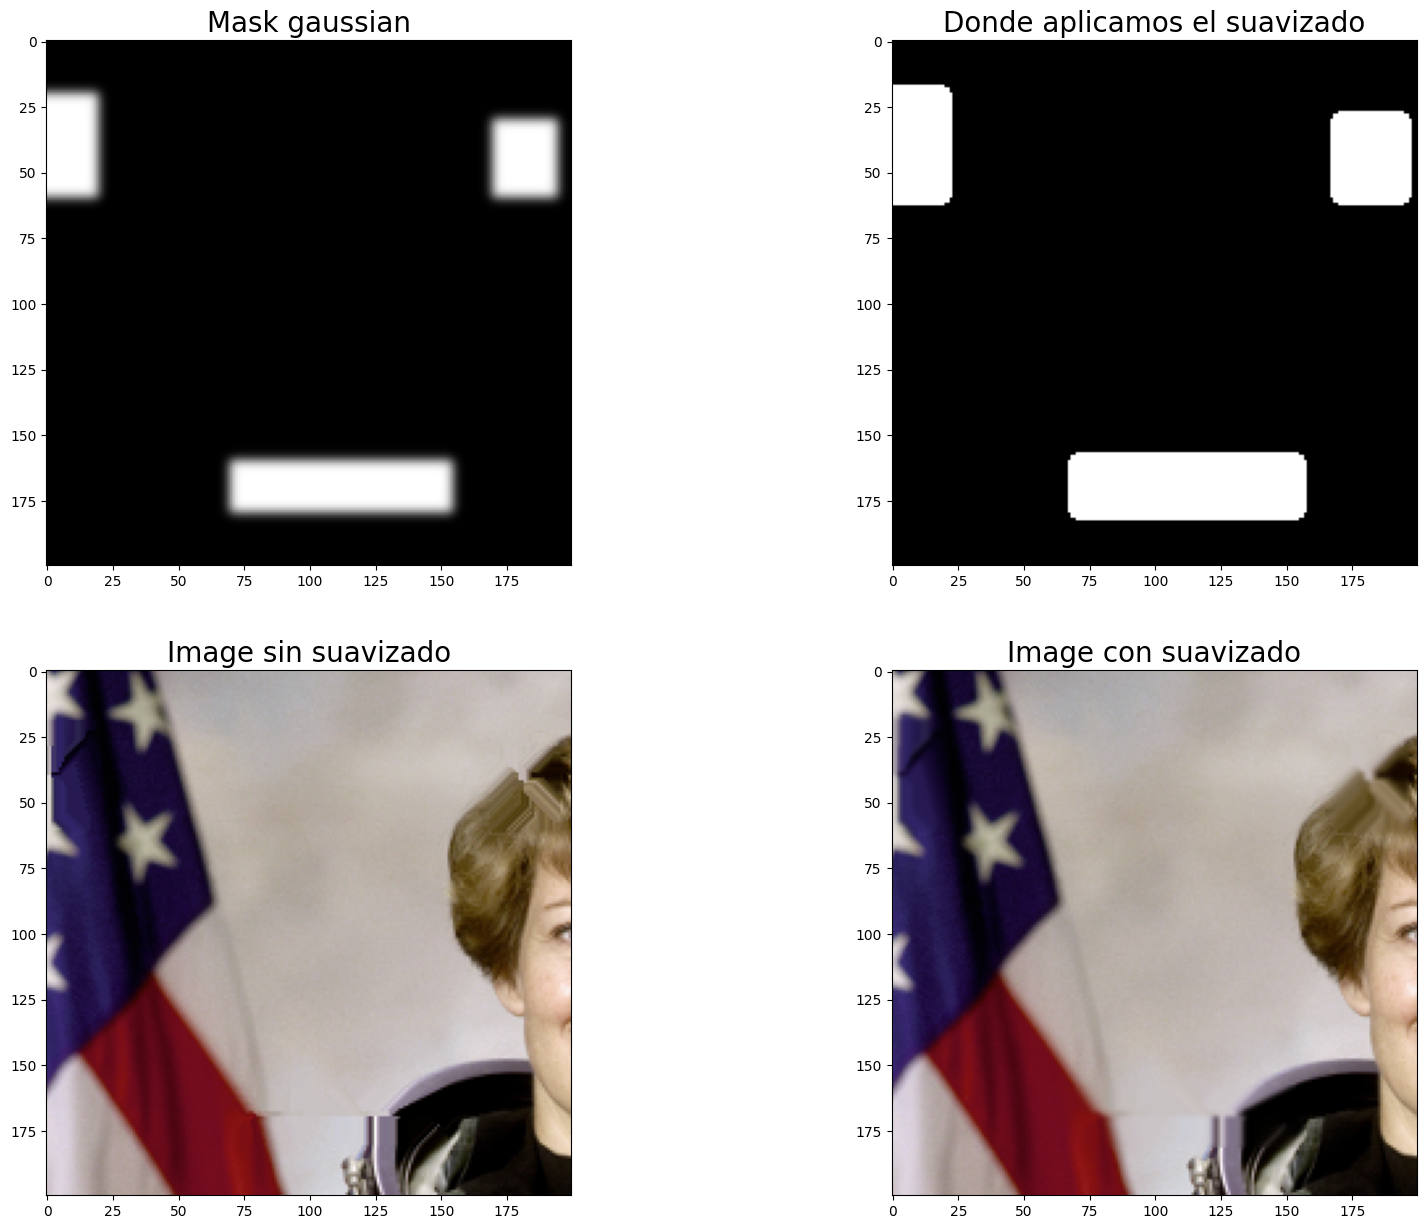

In [10]:
fig = plt.figure(figsize=(20, 15))

gaussian_mask = gaussian_filter(mask, 2.0, axes=(0, 1))

fig.add_subplot(2,2,1)
plt.title("Mask gaussian", fontdict=fontdict)
plt.imshow(gaussian_mask, cmap='gray')

fig.add_subplot(2,2,2)
plt.title("Donde aplicamos el suavizado", fontdict=fontdict)
plt.imshow(gaussian_mask > 0.05, cmap='gray')

fig.add_subplot(2,2,3)
plt.title("Image sin suavizado", fontdict=fontdict)
plt.imshow(fix_image(image_defect, mask, suavicacion=False), cmap='gray')

fig.add_subplot(2,2,4)
plt.title("Image con suavizado", fontdict=fontdict)
plt.imshow(fix_image(image_defect, mask), cmap='gray')

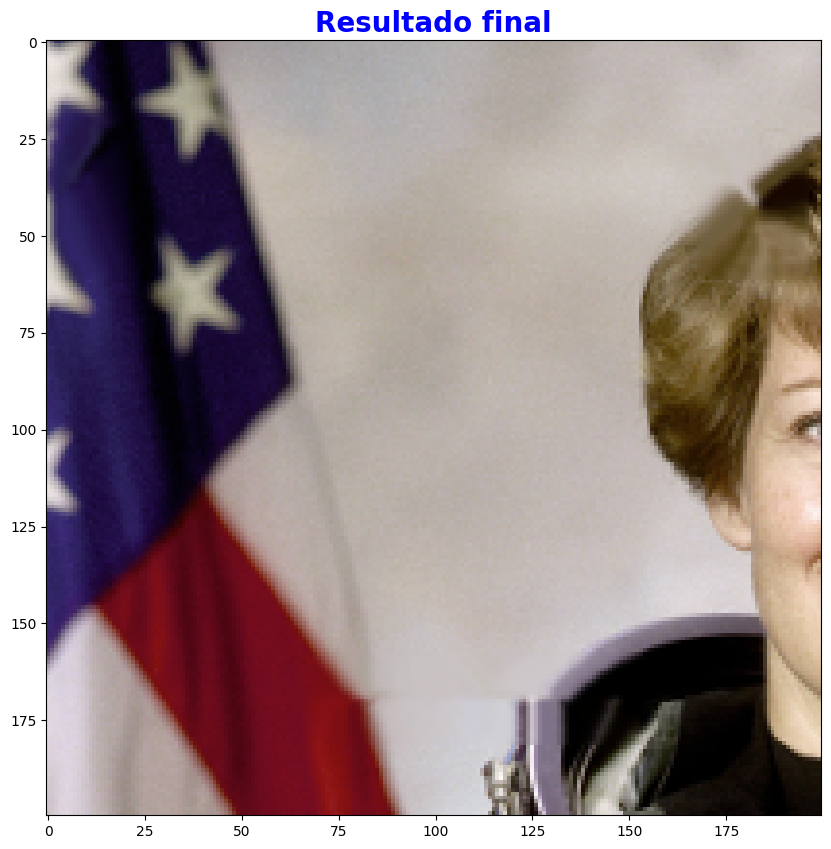

In [14]:
# Resultado final
plt.figure(figsize=(10, 15))
plt.title("Resultado final", fontdict={'fontsize': 20, 'weight': 'bold', 'color': 'blue'})
plt.imshow(fix_image(image_defect, mask, topn = 3), cmap='gray')